In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# Introduction

In [2]:
data = pd.read_csv('Dataset/emergency_classification.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       2352 non-null   object
 1   emergency_or_not  2352 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 36.9+ KB


In [4]:
data.head()

,image_names,emergency_or_not
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


In [5]:
data['emergency_or_not'].value_counts()

0    1361
1     991
Name: emergency_or_not, dtype: int64

In [6]:
X = []
for image_name in data['image_names']:
    img = plt.imread('Dataset/images/'+image_name)
    X.append(img)
X = np.array(X)

In [7]:
X.shape

(2352, 224, 224, 3)

In [8]:
y = data['emergency_or_not']

In [9]:
y.shape

(2352,)

In [10]:
rng = np.random.default_rng()

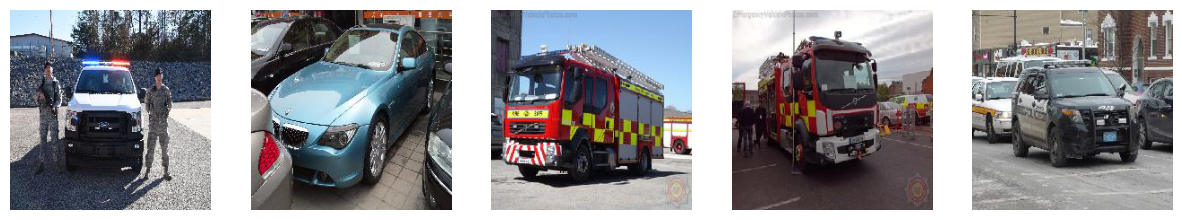

In [11]:
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(15,20))
for i in range(5):
    ax[i].imshow(X[rng.integers(X.shape[0])])
    ax[i].axis('off')

# Processing

In [12]:
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])

In [13]:
X.shape

(2352, 150528)

In [14]:
X.min(), X.max()

(0, 255)

In [15]:
X = X / X.max()

In [16]:
X.min(), X.max()

(0.0, 1.0)

In [17]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, det_curve
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, DetCurveDisplay, RocCurveDisplay, PrecisionRecallDisplay

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [19]:
X_train.shape, X_test.shape

((1646, 150528), (706, 150528))

# Model

In [20]:
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, concatenate

In [106]:
model=Sequential()
model.add(Dense(units=100, activation='sigmoid', input_shape=(X_train.shape[1],)))
model.add(Dense(units=1, activation='sigmoid'))

In [22]:
# summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               15052900  
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,053,001
Trainable params: 15,053,001
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer=keras.optimizers.SGD(), 
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=[keras.metrics.BinaryAccuracy()])

In [24]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
13/13 [==============================] - 8s 548ms/step - loss: 0.8619 - binary_accuracy: 0.5687 - val_loss: 0.6500 - val_binary_accuracy: 0.6006
Epoch 2/50
13/13 [==============================] - 2s 156ms/step - loss: 0.6506 - binary_accuracy: 0.6215 - val_loss: 0.6514 - val_binary_accuracy: 0.5892
Epoch 3/50
13/13 [==============================] - 2s 148ms/step - loss: 0.6215 - binary_accuracy: 0.6543 - val_loss: 0.6625 - val_binary_accuracy: 0.5878
Epoch 4/50
13/13 [==============================] - 2s 149ms/step - loss: 0.6189 - binary_accuracy: 0.6610 - val_loss: 0.5920 - val_binary_accuracy: 0.6941
Epoch 5/50
13/13 [==============================] - 2s 152ms/step - loss: 0.6311 - binary_accuracy: 0.6689 - val_loss: 0.6042 - val_binary_accuracy: 0.6714
Epoch 6/50
13/13 [==============================] - 2s 193ms/step - loss: 0.6269 - binary_accuracy: 0.6495 - val_loss: 0.6004 - val_binary_accuracy: 0.6742
Epoch 7/50
13/13 [==============================] - 2s 155ms/ste

In [67]:
prediction = model.predict(X_test)

23/23 [==============================] - 1s 24ms/step


In [68]:
prediction_cat = (prediction >= 0.5).astype(int)

In [69]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.70      0.86      0.77       396
           1       0.75      0.53      0.62       310

    accuracy                           0.72       706
   macro avg       0.73      0.70      0.70       706
weighted avg       0.72      0.72      0.71       706



In [28]:
history_df = pd.DataFrame(history.history)

In [29]:
history_df.head()

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.861873,0.568651,0.650047,0.600567
1,0.650641,0.621507,0.651361,0.589235
2,0.621458,0.654314,0.662465,0.587819
3,0.618947,0.660996,0.592006,0.694051
4,0.631105,0.668894,0.604152,0.671388


In [30]:
pd.melt(history_df.reset_index(), id_vars='index')

,index,variable,value
0,0,loss,0.861873
1,1,loss,0.650641
2,2,loss,0.621458
3,3,loss,0.618947
4,4,loss,0.631105
...,...,...,...
195,45,val_binary_accuracy,0.703966
196,46,val_binary_accuracy,0.701133
197,47,val_binary_accuracy,0.712465
198,48,val_binary_accuracy,0.713881


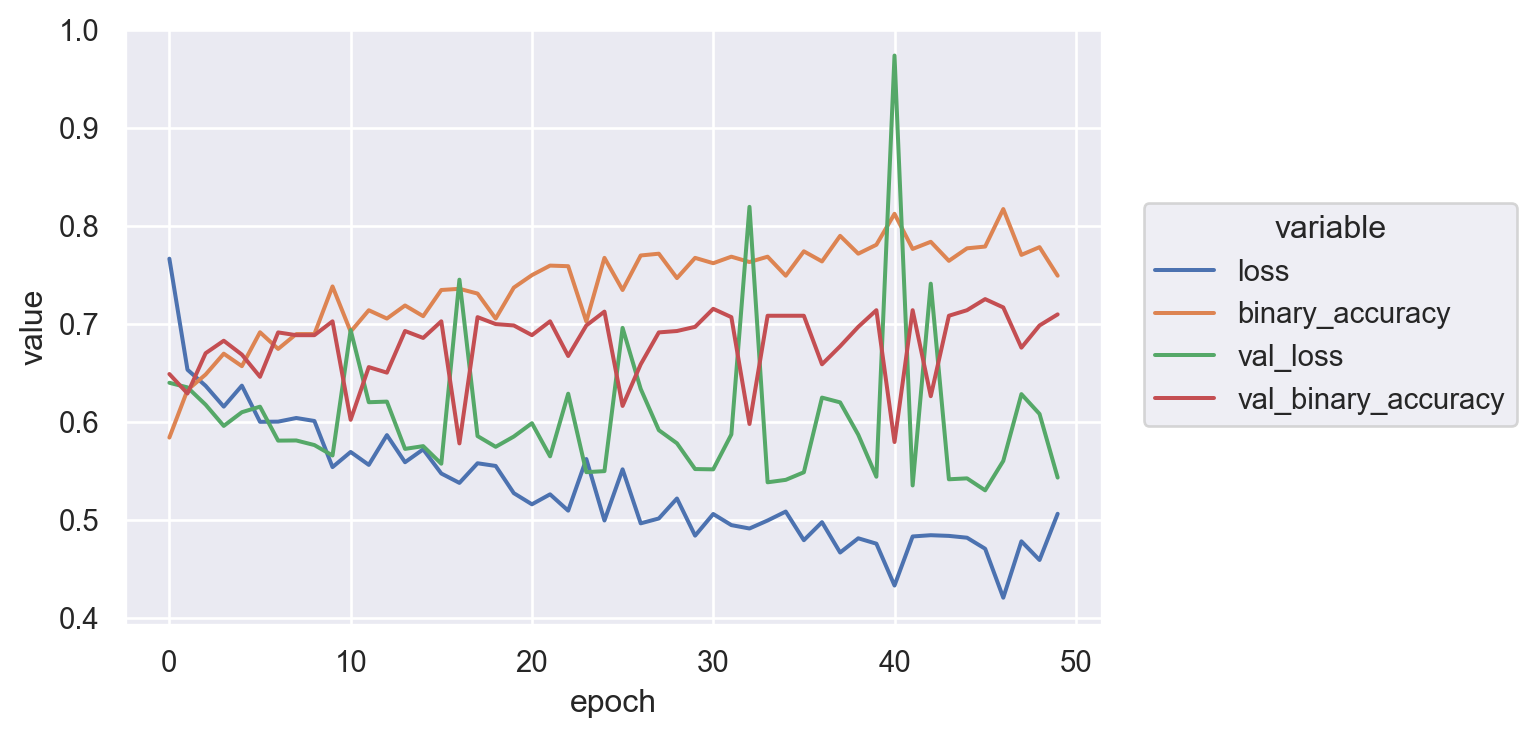

In [115]:
so.Plot(pd.melt(history_df.reset_index(), id_vars='index'), x='index', y='value', 
        color='variable').add(so.Line()).label(x='epoch').layout(size=(6,4))

Text(0.5, 0.01, 'epochs')

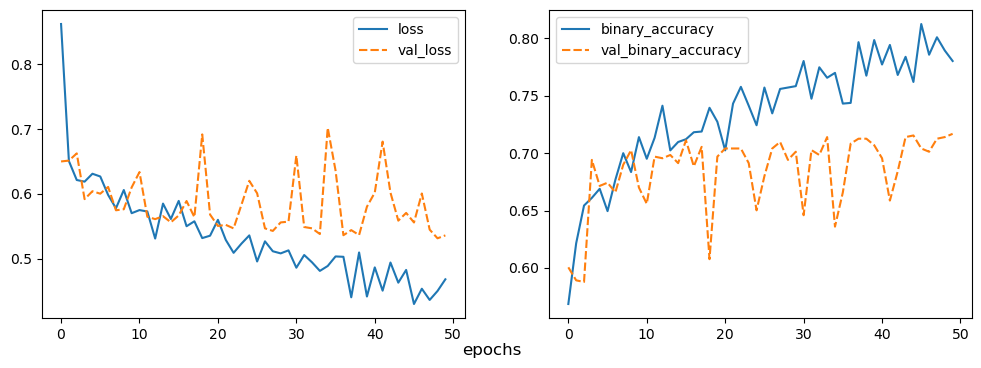

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

actual class 0, predicted probability 0.21764212846755981


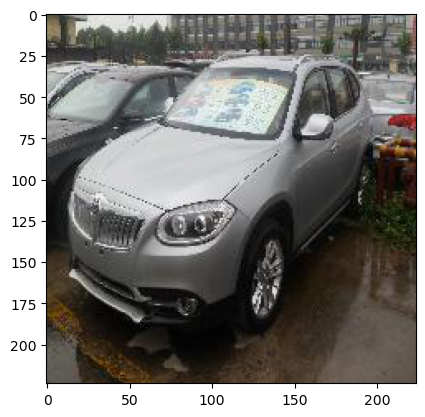

In [105]:
index = rng.integers(X_test.shape[0])
plt.imshow(np.reshape(X_test[index], (224,224,3)))
print(f'actual class {y_test.iloc[index]}, predicted probability {prediction[index][0]}')

# Hyper parameter tuning

## change activation function

In [107]:
model=Sequential()
model.add(Dense(units=100, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=1, activation='sigmoid'))

In [108]:
# summary of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,053,001
Trainable params: 15,053,001
Non-trainable params: 0
_________________________________________________________________


In [109]:
model.compile(optimizer=keras.optimizers.SGD(), 
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=[keras.metrics.BinaryAccuracy()])

In [110]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
13/13 [==============================] - 8s 506ms/step - loss: 1.5027 - binary_accuracy: 0.5802 - val_loss: 0.6918 - val_binary_accuracy: 0.5992
Epoch 2/50
13/13 [==============================] - 2s 182ms/step - loss: 0.6794 - binary_accuracy: 0.5838 - val_loss: 0.6788 - val_binary_accuracy: 0.6700
Epoch 3/50
13/13 [==============================] - 2s 156ms/step - loss: 0.6629 - binary_accuracy: 0.6075 - val_loss: 0.6542 - val_binary_accuracy: 0.6714
Epoch 4/50
13/13 [==============================] - 2s 149ms/step - loss: 0.6439 - binary_accuracy: 0.6434 - val_loss: 0.6346 - val_binary_accuracy: 0.6671
Epoch 5/50
13/13 [==============================] - 2s 160ms/step - loss: 0.6223 - binary_accuracy: 0.6744 - val_loss: 0.6365 - val_binary_accuracy: 0.6431
Epoch 6/50
13/13 [==============================] - 2s 149ms/step - loss: 0.6378 - binary_accuracy: 0.6397 - val_loss: 0.6203 - val_binary_accuracy: 0.6643
Epoch 7/50
13/13 [==============================] - 2s 144ms/ste

In [111]:
prediction = model.predict(X_test)

23/23 [==============================] - 1s 21ms/step


In [112]:
prediction_cat = (prediction >= 0.5).astype(int)

In [113]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.68      0.89      0.77       396
           1       0.77      0.47      0.58       310

    accuracy                           0.71       706
   macro avg       0.73      0.68      0.68       706
weighted avg       0.72      0.71      0.69       706



In [114]:
history_df = pd.DataFrame(history.history)

Text(0.5, 0.01, 'epochs')

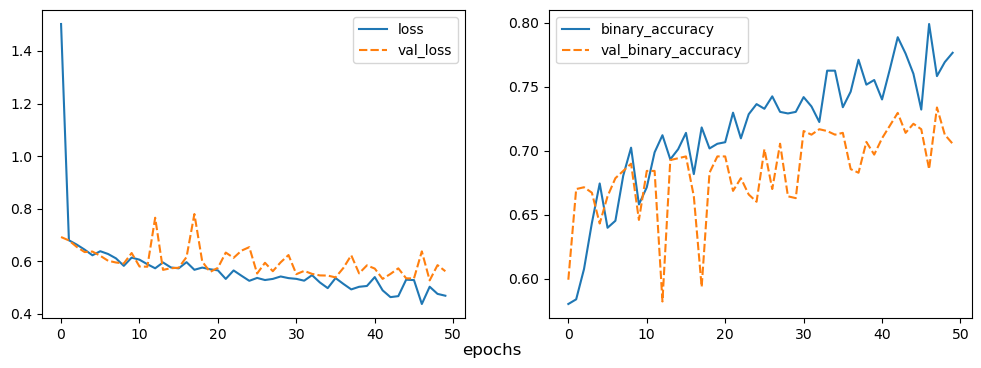

In [116]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

## increase hidden neurons

In [117]:
model=Sequential()
model.add(Dense(units=200, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=1, activation='sigmoid'))

In [118]:
# summary of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 200)               30105800  
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 30,106,001
Trainable params: 30,106,001
Non-trainable params: 0
_________________________________________________________________


In [119]:
model.compile(optimizer=keras.optimizers.SGD(), 
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=[keras.metrics.BinaryAccuracy()])

In [120]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
13/13 [==============================] - 11s 674ms/step - loss: 1.4976 - binary_accuracy: 0.5498 - val_loss: 0.7113 - val_binary_accuracy: 0.5609
Epoch 2/50
13/13 [==============================] - 4s 269ms/step - loss: 0.6670 - binary_accuracy: 0.6136 - val_loss: 0.6461 - val_binary_accuracy: 0.6714
Epoch 3/50
13/13 [==============================] - 3s 246ms/step - loss: 0.6522 - binary_accuracy: 0.6100 - val_loss: 0.6431 - val_binary_accuracy: 0.6615
Epoch 4/50
13/13 [==============================] - 3s 235ms/step - loss: 0.6380 - binary_accuracy: 0.6367 - val_loss: 0.6130 - val_binary_accuracy: 0.6785
Epoch 5/50
13/13 [==============================] - 3s 234ms/step - loss: 0.6112 - binary_accuracy: 0.6677 - val_loss: 0.6658 - val_binary_accuracy: 0.6006
Epoch 6/50
13/13 [==============================] - 3s 254ms/step - loss: 0.6364 - binary_accuracy: 0.6495 - val_loss: 0.6298 - val_binary_accuracy: 0.6445
Epoch 7/50
13/13 [==============================] - 3s 242ms/st

In [121]:
prediction = model.predict(X_test)

23/23 [==============================] - 1s 34ms/step


In [122]:
prediction_cat = (prediction >= 0.5).astype(int)

In [123]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.73      0.83      0.77       396
           1       0.73      0.60      0.66       310

    accuracy                           0.73       706
   macro avg       0.73      0.71      0.72       706
weighted avg       0.73      0.73      0.72       706



In [124]:
history_df = pd.DataFrame(history.history)

Text(0.5, 0.01, 'epochs')

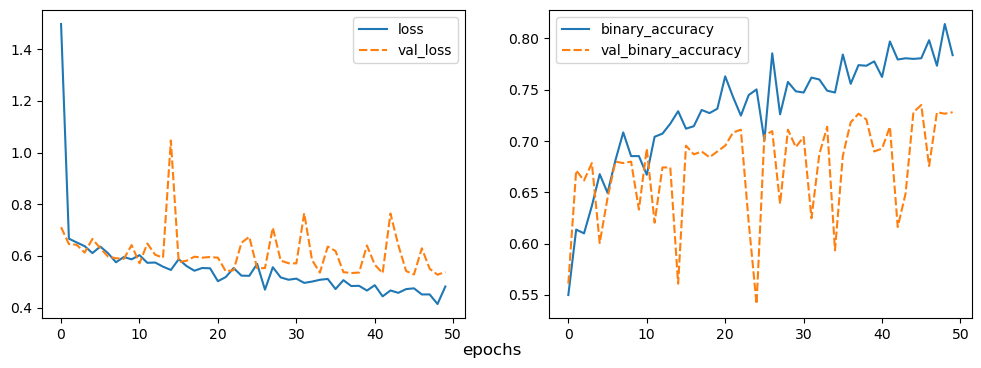

In [125]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

## increase hidden layers

In [126]:
model=Sequential()
model.add(Dense(units=100, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [127]:
# summary of the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               15052900  
                                                                 
 dense_9 (Dense)             (None, 100)               10100     
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 15,063,101
Trainable params: 15,063,101
Non-trainable params: 0
_________________________________________________________________


In [128]:
model.compile(optimizer=keras.optimizers.SGD(), 
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=[keras.metrics.BinaryAccuracy()])

In [129]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
13/13 [==============================] - 8s 606ms/step - loss: 1.5475 - binary_accuracy: 0.5656 - val_loss: 0.6759 - val_binary_accuracy: 0.6501
Epoch 2/50
13/13 [==============================] - 3s 220ms/step - loss: 0.6572 - binary_accuracy: 0.6264 - val_loss: 0.6685 - val_binary_accuracy: 0.5652
Epoch 3/50
13/13 [==============================] - 2s 165ms/step - loss: 0.6763 - binary_accuracy: 0.5814 - val_loss: 0.7195 - val_binary_accuracy: 0.5609
Epoch 4/50
13/13 [==============================] - 2s 167ms/step - loss: 0.6503 - binary_accuracy: 0.6349 - val_loss: 0.6458 - val_binary_accuracy: 0.6204
Epoch 5/50
13/13 [==============================] - 2s 178ms/step - loss: 0.6164 - binary_accuracy: 0.6659 - val_loss: 0.6383 - val_binary_accuracy: 0.6374
Epoch 6/50
13/13 [==============================] - 2s 174ms/step - loss: 0.6334 - binary_accuracy: 0.6634 - val_loss: 0.6168 - val_binary_accuracy: 0.6643
Epoch 7/50
13/13 [==============================] - 2s 150ms/ste

In [130]:
prediction = model.predict(X_test)

23/23 [==============================] - 1s 30ms/step


In [131]:
prediction_cat = (prediction >= 0.5).astype(int)

In [132]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.58      0.99      0.73       396
           1       0.88      0.09      0.17       310

    accuracy                           0.60       706
   macro avg       0.73      0.54      0.45       706
weighted avg       0.71      0.60      0.49       706



In [133]:
history_df = pd.DataFrame(history.history)

Text(0.5, 0.01, 'epochs')

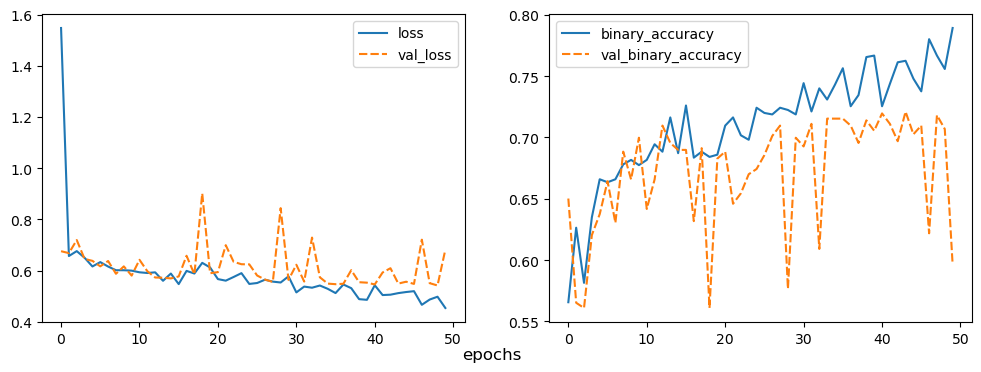

In [134]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

## change epochs

In [146]:
model=Sequential()
model.add(Dense(units=100, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [147]:
# summary of the model
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 100)               15052900  
                                                                 
 dense_18 (Dense)            (None, 100)               10100     
                                                                 
 dense_19 (Dense)            (None, 1)                 101       
                                                                 
Total params: 15,063,101
Trainable params: 15,063,101
Non-trainable params: 0
_________________________________________________________________


In [148]:
model.compile(optimizer=keras.optimizers.SGD(), 
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=[keras.metrics.BinaryAccuracy()])

In [149]:
history = model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, validation_data=(X_test, y_test))

Epoch 1/100
13/13 [==============================] - 9s 508ms/step - loss: 1.1317 - binary_accuracy: 0.4951 - val_loss: 0.6815 - val_binary_accuracy: 0.5609
Epoch 2/100
13/13 [==============================] - 3s 260ms/step - loss: 0.6838 - binary_accuracy: 0.5547 - val_loss: 0.6562 - val_binary_accuracy: 0.6459
Epoch 3/100
13/13 [==============================] - 2s 159ms/step - loss: 0.6706 - binary_accuracy: 0.6130 - val_loss: 0.6458 - val_binary_accuracy: 0.6331
Epoch 4/100
13/13 [==============================] - 2s 147ms/step - loss: 0.6464 - binary_accuracy: 0.6252 - val_loss: 0.6204 - val_binary_accuracy: 0.6700
Epoch 5/100
13/13 [==============================] - 2s 175ms/step - loss: 0.6467 - binary_accuracy: 0.6337 - val_loss: 0.6608 - val_binary_accuracy: 0.5949
Epoch 6/100
13/13 [==============================] - 3s 208ms/step - loss: 0.6031 - binary_accuracy: 0.6786 - val_loss: 0.6826 - val_binary_accuracy: 0.5977
Epoch 7/100
13/13 [==============================] - 3s 21

In [150]:
prediction = model.predict(X_test)

23/23 [==============================] - 1s 22ms/step


In [151]:
prediction_cat = (prediction >= 0.5).astype(int)

In [152]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.60      0.99      0.75       396
           1       0.94      0.15      0.26       310

    accuracy                           0.62       706
   macro avg       0.77      0.57      0.50       706
weighted avg       0.75      0.62      0.53       706



In [153]:
history_df = pd.DataFrame(history.history)

Text(0.5, 0.01, 'epochs')

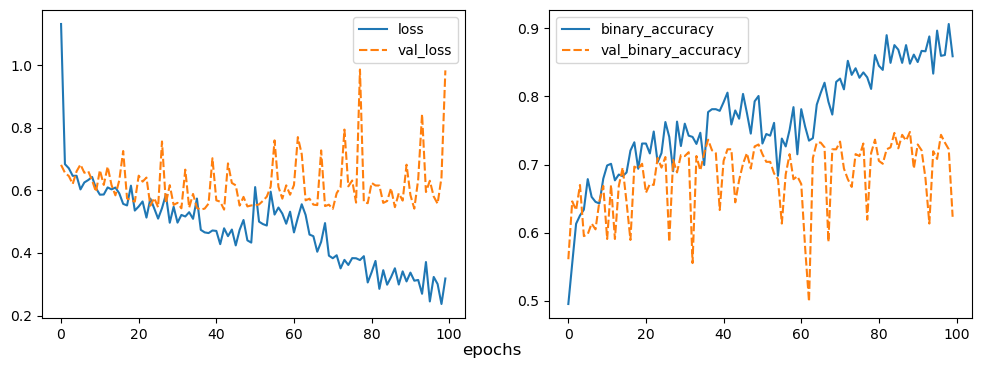

In [154]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

## change optimizer

In [155]:
model=Sequential()
model.add(Dense(units=100, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [156]:
# summary of the model
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 100)               15052900  
                                                                 
 dense_21 (Dense)            (None, 100)               10100     
                                                                 
 dense_22 (Dense)            (None, 1)                 101       
                                                                 
Total params: 15,063,101
Trainable params: 15,063,101
Non-trainable params: 0
_________________________________________________________________


In [157]:
model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=[keras.metrics.BinaryAccuracy()])

In [158]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
13/13 [==============================] - 13s 907ms/step - loss: 9.8080 - binary_accuracy: 0.5334 - val_loss: 0.7597 - val_binary_accuracy: 0.6629
Epoch 2/50
13/13 [==============================] - 4s 338ms/step - loss: 1.6792 - binary_accuracy: 0.6045 - val_loss: 0.8767 - val_binary_accuracy: 0.6827
Epoch 3/50
13/13 [==============================] - 4s 292ms/step - loss: 1.1596 - binary_accuracy: 0.6179 - val_loss: 0.7576 - val_binary_accuracy: 0.6813
Epoch 4/50
13/13 [==============================] - 4s 351ms/step - loss: 1.0415 - binary_accuracy: 0.6446 - val_loss: 1.5103 - val_binary_accuracy: 0.6076
Epoch 5/50
13/13 [==============================] - 4s 329ms/step - loss: 0.8287 - binary_accuracy: 0.6762 - val_loss: 0.5991 - val_binary_accuracy: 0.7040
Epoch 6/50
13/13 [==============================] - 4s 293ms/step - loss: 0.6422 - binary_accuracy: 0.7224 - val_loss: 1.0851 - val_binary_accuracy: 0.6091
Epoch 7/50
13/13 [==============================] - 4s 330ms/st

In [159]:
prediction = model.predict(X_test)

23/23 [==============================] - 1s 20ms/step


In [160]:
prediction_cat = (prediction >= 0.5).astype(int)

In [161]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       396
           1       0.73      0.70      0.71       310

    accuracy                           0.75       706
   macro avg       0.75      0.75      0.75       706
weighted avg       0.75      0.75      0.75       706



In [162]:
history_df = pd.DataFrame(history.history)

Text(0.5, 0.01, 'epochs')

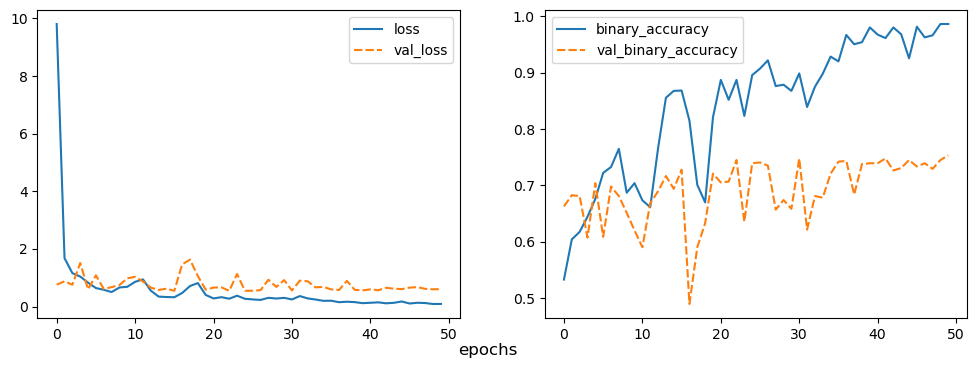

In [163]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')